In [1]:
import itertools
import random

%matplotlib inline
import networkx as nx


# 第5章

目次：

1. [Python の `random` モジュール](#1.-Python&#39;s-random-module)
2. [ランダムネットワークモデル](#2.-Random-Network-Model)
3. [スモールワールドモデル](#3.-Small-World-Model)
4. [優先的選択モデル](#4.-Preferential-Attachment-Model)

このチュートリアルで紹介する各モデルについて、モデルを生成するためのアルゴリズム、実装例、および対応する NetworkX を利用するコードを紹介する。このチュートリアルで提供される実装は、効率のためではなく、わかりやすさを重視して書かれている。そのため、実際の分析作業を行う場合は、NetworkX 関数を使用することをお勧めしたい。



## 1. Python の`random`モジュール

多くのネットワークモデルは、生成アルゴリズムのランダム性に依存している。Python の [random](https://docs.python.org/3.7/library/random.html) モジュールは、ネットワークモデルをコーディングする際に 4 つの主要な関数を提供している。

###  `random.random`

アルゴリズムでは、ある確率 $p$ で何かが発生する必要がある。そのような事象が発生するかどうかを決定する標準的な方法は、0 と 1 の間の乱数 $r$ を生成することである。$r < p$ の場合、事象が発生する。 [random.random()](https://docs.python.org/3.7/library/random.html#random.random) 関数は、まさにそのような乱数を間隔 $[0, 1)$ 返す。

簡単な例として、75% の確率で表が出る不公平なコインを考えてみよう。次のコードを入力して、そのコインを 10 回投げ、それぞれの結果を報告する。


In [2]:
p = 0.75

# Do this 10 times
for _ in range(10):
    r = random.random()
    if r < p:
        print('Heads')
    else:
        print('Tails')

Heads
Heads
Tails
Tails
Heads
Heads
Heads
Heads
Heads
Heads



ランダムな過程から予想されるように、前のセルを再度実行すると、それぞれ異なるフリップのシーケンスが独自に生成される。

###  `random.choice`

離散的な選択肢の母集団があり、そのうちの 1 つをランダムに選択する必要がある場合は、 [random.choice()](https://docs.python.org/3.7/library/random.html#random.choice) を使用する。例えば、下に示したように、「[eeny、meeny、miny、moe](https://en.wikipedia.org/wiki/Eeny,_meeny,_miny,_moe)」の代わりに、 `random.choice` を使用してランダムに名前を選択する。


In [3]:
names = ['Alice', 'Bob', 'Cathy', 'Dan']
random.choice(names)

'Cathy'


### `random.sample`

コレクションがあり、置換せずに複数の要素を選択する必要がある場合は、[random.sample()](https://docs.python.org/3.7/library/random.html#random.sample) を使用する。例えば、グラフ内のノードからランダムに 2 つのノードを選択するには、次のコードを使用する。


In [4]:
G = nx.cycle_graph(5)
random.sample(G.nodes, 2)

since Python 3.9 and will be removed in a subsequent version.
  random.sample(G.nodes, 2)


[3, 0]


### `random.choices`

各要素を選択する確率が同じでない場合に、コレクションから要素を選択したい場合は、[random.choices()](https://docs.python.org/3.7/library/random.html#random.choices)を使用する。

例えば、Alice、Bob、Carol がくじ引きに参加しているとする。アリスは 1 枚、ボブは 3 枚、キャロルは 4 枚の抽選券を購入した。このくじの10通りの抽選を、毎回抽選券を以下のコードと入れ替えてシミュレートできる。


In [5]:
names = ['Alice', 'Bob', 'Carol']
tickets = [1, 3, 4]

for _ in range(10):
    print(random.choices(names, tickets))

['Carol']
['Bob']
['Carol']
['Alice']
['Alice']
['Bob']
['Bob']
['Carol']
['Carol']
['Bob']



上記のセルを実行すると、予想どおりCarol が最も頻繁に当選し、Bob が次に多く、そしてAlice がたまに当選するという結果が得られるはずだ。もちろん、この結果はくじの運次第である！

キーワード引数 `k=` を指定することで、 データから *k* 個のアイテムを置換して選択できる。


In [6]:
random.choices(names, tickets, k=10)

['Bob',
 'Carol',
 'Bob',
 'Carol',
 'Bob',
 'Bob',
 'Carol',
 'Alice',
 'Alice',
 'Carol']


`random.choices` に提供される重みは必ずしも整数とは限らず、数値であれば問題はない。



## 2. ランダムネットワークモデル

ギルバートによって定式化されたランダムネットワークモデルには、ノード数 $N$ とリンク確率 $p$ の 2 つのパラメーターがある。本書で提示されたように、このネットワークを作成するためのアルゴリズムは次の手順で得られる：

1. ノードのペア、ここでは i と j を選択する
2. 0 から 1 の間の乱数 r を生成する。r < p の場合、i と j の間にリンクを追加する
3. すべてのノードペアに対して (1) と (2) を繰り返す

このタスクには、Python のいくつかのツールが必要である

### 組み合わせの生成

これまでに、グラフのすべてのノードやすべてのエッジをループ処理したが、このアルゴリズムでは、ノードのすべての*ペア*、つまりすべての可能なエッジをループ処理する必要がある。 Python の標準ライブラリの `itertools` モジュールには、一連の要素のペアをループする、[combinations()](https://docs.python.org/3.7/library/itertools.html#itertools.combinations) 関数がある。


In [7]:
elements = [0, 1, 2, 3, 4]
list(itertools.combinations(elements, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]


`itertools.combinations()` の 2 番目の引数は、出力に必要なシーケンスの長さである。ペアが必要なので、2 を指定する。出力に以下の優れた性質をもっている：

1. 繰り返し要素がないので`('a', 'a')` のような自己ループは考慮しない。
2. ペアはソートされた順序になっている。無向グラフの文脈で `('a', 'b')` と `('b', 'a')` は同じエッジであるため、ちょうどこの性質を満たす。

したがって、これを使用して、グラフ内のすべてのノードペアをループできる。


In [8]:
G = nx.Graph()
G.add_nodes_from(elements)

list(itertools.combinations(G.nodes, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]


### Gilbert ランダムグラフモデル

ツールボックスのこれらのツールを使用して、Gilbert ランダムグラフモデルのアルゴリズム作ることができる。


In [9]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    for i, j in itertools.combinations(G.nodes, 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p
        
    return G


この関数を使用すれば所定の手順でグラフを生成できる。ランダムなアルゴリズムであるため、実行するたびに異なるグラフが生成される。


In [ ]:
G = gnp_random_graph(16, 0.15)
nx.draw(G)
print('Graph has', G.number_of_edges(), 'edges.')

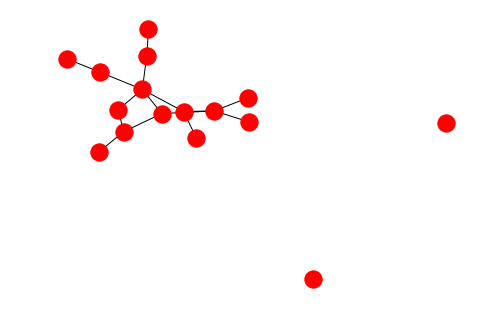


上記のセルを数回実行すると、同じパラメーターで生成されたランダム・グラフ間で、エッジの数がわずかに異なることに注意されたい。これは、ノードの各ペアがそれぞれ独立にエッジになる確率をもっているためである。



### エルデシュ・レニィ ランダムグラフモデル

リンク確率 $p$ を指定する代わりに、 `random.sample()` を使用して `itertools.combinations()` で生成された可能なエッジの M を選択することにより、ちょうど $M$ 個のエッジを持つ $N$ 個のノードのグラフを生成することもできる。


In [11]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G.nodes, 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)
    
    return G

In [ ]:
G = gnm_random_graph(16, 18)
nx.draw(G)

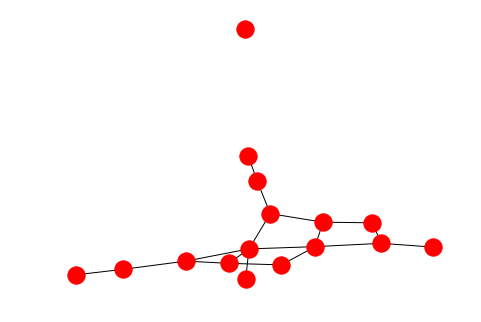


### NetworkX の関数

NetworkX には、ノード数 $N$ とリンク確率 $p$ を指定する $G_{n,p}$ ランダムグラフの関数 [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html) が提供される。

さらに、NetworkX は $G_{n,m}$ グラフを生成する [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html) を提供する。ここで、ノード数 $N$ と必要なエッジ数 $M$ を指定する必要がある。



## 3. スモールワールドモデル

スモールワールドネットワークを生成するアルゴリズムは

1. $N$ 個のノードの環状ネットワークから始める
2. 各ノードをその $k$ (k が奇数の場合は $k-1$) 個の最近傍のノードに繋ぐ
3. 各エッジ $(u, v)$ について、確率 $p$ で、エッジ $(u, v)$ を $(u, w)$ に置き換える。ただし、$w$ は $u$ の近傍以外のランダムに選ばれたノードである。


まずはこれらを順番に実行し、最後に１つの関数にまとめる。

###  N 個のノードからなるリングを作成する

In [ ]:
N = 10
G = nx.cycle_graph(N)
nx.draw_circular(G, with_labels=True)

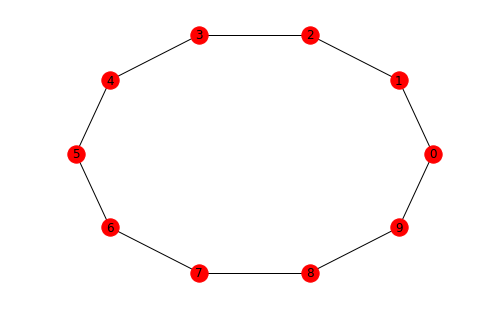


### 各ノードとその $k$-最近傍を繋ぐ

これを行うためにモジュラー算術を使用する。理由として、例えば、$k$ が 4 であるとする。ノード $n$ の場合、$n$ とその 4 つの最近傍：$n-1$、$n+1$、$n-2$ および $n+2$　の間にエッジを作る。ノードはリングの中にあるため、これらは「ラップ・アラウンド」できる。*例えば*、ノード $0$ の 4 つの最近傍は $N-1$、$1$、$N-2$、および $2$ である。

以下の整数除算 (//) は、除算の小数部分を捨てる演算である。例えば、

    5 // 2 = 2

In [ ]:
k = 4

for n in G.nodes:
    for i in range(1, k // 2 + 1):
        left  = (n-i) % N
        right = (n+i) % N 
        G.add_edge(n, left)
        G.add_edge(n, right)

nx.draw_circular(G, with_labels=True)

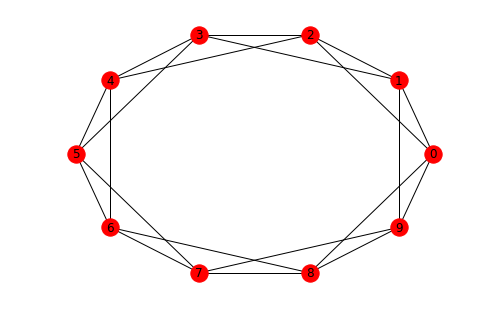


### エッジを置換する

>  各エッジ $(u, v)$ について、確率 $p$ で、エッジ $(u, v)$ を $(u, w)$ に置換する。ただし、$w$ は $u$ の近傍以外のランダムに選ばれたノードである。

このステップでは、集合演算を使用して $u$ の隣接ノードでないノードのリストを生成し、 `random.choice` を使用してその「隣接しない」セットからランダムに $w$ を選択する。


In [ ]:
p = 0.1

for u, v in list(G.edges):
    if random.random() < p:
        not_neighbors = set(G.nodes) - set(G.neighbors(u))
        w = random.choice(list(not_neighbors))
        G.remove_edge(u, v)
        G.add_edge(u, w)

nx.draw_circular(G, with_labels=True)

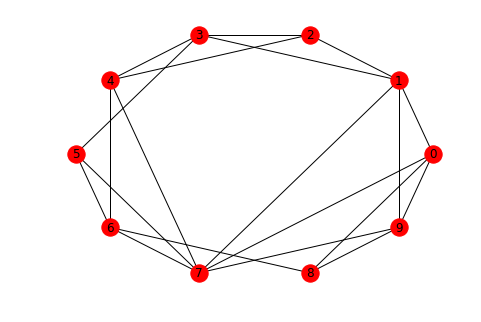


### ワッツ・ストロガッツ スモールワールドモデル

これをまとめることで、スモールワールドモデルの基本的な関数を書くことができる。


In [16]:
def watts_strogatz_graph(N, k, p):
    # _1. N個のノードからなるリングを作る_
    G = nx.cycle_graph(N)

    # _2. 各ノードnをk個の最近接ノードに接続する_
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes:
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)
    
    # _3. 確率pでエッジを配線し直す_
    for u, v in list(G.edges):
        if random.random() < p:
            not_neighbors = set(G.nodes) - set(G.neighbors(u)) - {u}
            w = random.choice(list(not_neighbors))
            G.remove_edge(u, v)
            G.add_edge(u, w)

    return G

In [ ]:
G = watts_strogatz_graph(16, 4, 0.2)
nx.draw_circular(G, with_labels=True)

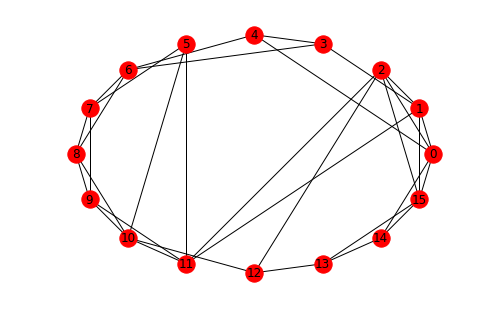


### NetworkX 関数

NetworkX には、このモデル用の関数 [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html) がある。



## 4. 優先的選択モデル

バラバシ・アルバートの優先的選択（Preferential Attachment）モデルには、ノードの数 $N$ と、各ステップで追加されるリンクの数 $m$ の 2 つのパラメーターがある。これらのパラメータが与えられると、アルゴリズムは：

1. $m + 1$ 個のノードの任意のグラフから始める
2. 次数によって重み付けされた $m$ 個の異なるノードをランダムに選択する
3. 新しいノード $i$ を追加し、前のステップの $m$ 個のノードとリンクする
4. グラフに N 個のノードが存在するまで、2 ～ 3 を繰り返す

このコードは簡単だが、１つだけ例外がある。ステップ 3 では、ランダムな選択に重みを付けるために*次数のシーケンス*を生成する必要がある。グラフ `G` があれば、次のようにリスト内包表記を使用して次数のシーケンスを生成できる。

In [ ]:
G = nx.star_graph(4)
degrees = [G.degree(n) for n in G.nodes]

print(degrees)
nx.draw(G, with_labels=True)

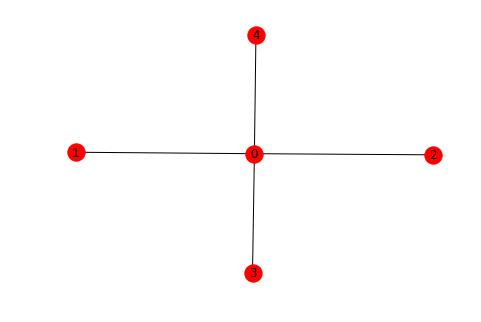


次数のシーケンスはノードと同じ順序で出力される。そのため、そのリストのインデックス $i$ のノードは、対応する次数のシーケンスのインデックス $i$ の次数を持つ。これにより、BA優先的選択モデルの関数は以下のように実装できる。

In [19]:
def barabasi_albert_graph(N, m):
    # 1. ＊m+1個のノードのクリークから始める＊
    G = nx.complete_graph(m + 1)
    for i in range(G.number_of_nodes(), N):
        # 2. ＊m個の異なるノードをランダムに選択し、次数で重み付けする.＊
        new_neighbors = []
        possible_neighbors = list(G.nodes)
        for _ in range(m):
            degrees = [G.degree(n) for n in possible_neighbors]
            j = random.choices(possible_neighbors, degrees)[0]
            new_neighbors.append(j)
            possible_neighbors.remove(j)
        
        # 3. 新しいノードiを追加し、前のステップのm個のノードとリンクする
        for j in new_neighbors:
            G.add_edge(i, j)

    return G

In [ ]:
G = barabasi_albert_graph(30, 1)
nx.draw(G)

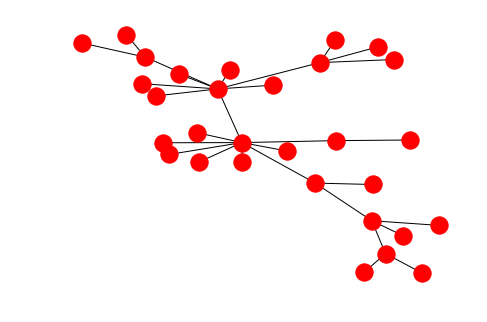


先ほどの`preferential_attachment_graph`のコードで、ステップ 2 を単に
```
new_neighbors = random.choices(G.nodes, degrees, k=m)
```
というより簡単な書き方にしないことに疑問を抱いているかもしれない。それは `random.choices` に $k > 1$ を指定すると、選択が交換ありで行われるためである。つまり、同じノードがリストから複数回選択される可能性がある。ノード $i$ と結合する $m$ 個の異なるノードを選択するには、より複雑なコードが必要である。

###  NetworkX 関数

今まで紹介したすべてのグラフモデルと同様に、NetworkX には BA モデルを生成する関数 [barabasi_albert_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html) がある。
